# Imports

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.utils.data import DataLoader, WeightedRandomSampler
from collections import Counter
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
import torch
import torchvision.models as models
import torch.optim as optim
import os
from PIL import Image
from clouds import *



c:\Users\jseto\inat_bot\inatbot\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\jseto\inat_bot\inatbot\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


# Data Loading

In [ ]:
#Downloading data
! pip install -q kaggle
from google.colab import files
from PIL import Image
import pandas as pd

In [ ]:
#upload ur kaggle json file/
files.upload()

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d 'mmichelli/cirrus-cumulus-stratus-nimbus-ccsn-database' #user-id/name


In [ ]:
!mkdir data
!unzip cirrus-cumulus-stratus-nimbus-ccsn-database.zip -d data
!mv data/CCSN_v2 data/cloud_data


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

In [ ]:

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.ColorJitter(brightness=0.15, contrast=0.10, saturation=0.1, hue=0.02),
    transforms.GaussianBlur(kernel_size=3),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.15),
    transforms.Normalize([0.485, 0.456,0.406],
                        [0.229, 0.224, 0.225]),
])

resnet_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456,0.406],
                         [0.229, 0.224, 0.225]),
                         ]
)
data_dir = "data/cloud_data"
dataset = datasets.ImageFolder(root=data_dir, transform=train_transforms) #Note.
clean_data = datasets.ImageFolder(root=data_dir, transform=resnet_transforms)

all_indices = list(range(len(dataset)))
class_distribution = [221, 188, 242, 268, 287, 139, 200, 182, 274, 340, 202]  # or dataset.targets

#Getting all labels for the stratify split
all_labels = []
for i in range(len(class_distribution)):
  all_labels  += [i] * class_distribution[i]

train_indices,test_indices = train_test_split(
    all_indices,
    test_size=0.2,
    stratify=all_labels,
)

#Take the subset from the stratified split
train_data = Subset(dataset, train_indices)
test_data = Subset(clean_data, test_indices)

#make the sampler thingy
train_labels = [dataset.targets[i] for i in train_indices]
label_counts = Counter(train_labels)
class_sample_count = np.array([label_counts[i] for i in range(len(label_counts))])
weights = 1. / class_sample_count
sample_weights = [weights[label] for label in train_labels]
train_sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

#actually use the sampler thingy
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

h_labels = [0] * 11
for key in dataset.class_to_idx:
  h_labels[dataset.class_to_idx[key]] = key

human_labels = ["Altocumulus", "Altostratus", "Cumulonimbus","Cirrocumulus", "Cirrus", "Cirrostratus", "Contrail", "Cumulus",
                 "Nimbus", "Stratocumulus", "Stratus" ] #human readable labels

# Data

In [ ]:
from sklearn.metrics import classification_report


def eval_model(model, test_loader, human_labels=h_labels):
    running_acc = 0
    y_true, y_pred = [], []
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        with torch.no_grad():
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)
            running_acc += torch.sum(torch.argmax(outputs, dim = 1) == labels) / len(labels)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    print(classification_report(y_true, y_pred, target_names=human_labels))
    return running_acc / len(test_loader)


In [ ]:
def train(model,train_loader, test_loader, criterion, optimizer, scheduler, model_fp, num_epochs=10, batches_to_print=20):
    print("starting training")
    best_acc = 0

    for epoch in range(num_epochs):

        running_loss = 0
        running_acc = 0

        for i, data in enumerate(train_loader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            model.train() #if we ever decide to batchnorm later. jujst tells it that we're in training mode rn
            optimizer.zero_grad() #zero grad

            outputs = model(inputs) #fd it

            acc = torch.sum(torch.argmax(outputs, dim = 1) == labels) / len(labels)
            loss = criterion(outputs, labels)
            # print(torch.argmax(outputs, 1))

            loss.backward()
            optimizer.step()

            running_acc += acc.item()
            running_loss += loss.item()

            if i % batches_to_print == batches_to_print - 1:    # print every 20 batches
                print(f'Epoch {epoch + 1} batcj {i + 1} loss: {running_loss / batches_to_print:.3f} acc {running_acc / batches_to_print:.3f}')
                running_acc = 0
                running_loss = 0

        if test_loader is not None:
            test_acc = eval_model(model, test_loader)
            print(f"tested at {test_acc}")
            if test_acc > best_acc and epoch >= 2 and (model_fp != None):
                best_acc = test_acc
                print(f"Saving model at {model_fp}")
                torch.save(model.state_dict(), model_fp)
            scheduler.step(test_acc)

    print(f'Finished Training. Model saved has acc {best_acc}')

# Resnet

In [ ]:
#Show some of the images before/after transform to make sure its not tweaking
from PIL import Image

test_img = Image.open("data/cloud_data/Cu/Cu-N012.jpg")

fig, axes = plt.subplots(3, 2)

for ax in axes.flat[1:]:
    ax.imshow(torch.permute(train_transforms(test_img), [1, 2, 0]))

axes.flat[0].imshow(torch.permute(train_transforms(test_img), [1, 2, 0]))


plt.imshow(test_img)

In [ ]:
for img, label in dataset:
  plt.imshow(torch.permute(img, [1, 2, 0]))

  print(label)
  break

In [ ]:
from torchvision import models


# for param in resnet.parameters():
#     param.requires_grad = False

# for param in resnet.layer4.parameters():
#     param.requires_grad = True

# resnet.fc = nn.Linear(resnet.fc.in_features, 11)


In [ ]:

def freeze_module(module):
    for param in module.parameters():
        param.requires_grad = False

def unfreeze_module(module):
    for param in module.parameters():
        param.requires_grad = True

def make_optimizer_and_scheduler(model, lr=1e-3):
    params = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = optim.Adam(params, lr=lr, weight_decay=1e-5)
    return optimizer, torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)


resnet = models.resnet152(pretrained=True)

for param in resnet.parameters():
    param.requires_grad = False

resnet.fc = nn.Linear(resnet.fc.in_features, 11)
criterion = nn.CrossEntropyLoss() #Multi class loss
resnet.to('cuda')


In [ ]:
unfreeze_module(resnet.layer1)
optimizer, scheduler = make_optimizer_and_scheduler(resnet)
train(resnet, train_loader, test_loader, criterion=criterion, optimizer=optimizer, model_fp= "resnet2.pth", scheduler=scheduler, num_epochs = 20)



starting training
Epoch 1 batcj 20 loss: 0.588 acc 0.822
              precision    recall  f1-score   support

          Ac       0.33      0.41      0.37        44
          As       0.43      0.47      0.45        38
          Cb       0.58      0.75      0.65        48
          Cc       0.45      0.39      0.42        54
          Ci       0.28      0.35      0.31        31
          Cs       0.37      0.27      0.31        55
          Ct       0.74      0.80      0.77        40
          Cu       0.42      0.44      0.43        36
          Ns       0.36      0.22      0.27        55
          Sc       0.47      0.34      0.39        68
          St       0.21      0.33      0.26        40

    accuracy                           0.42       509
   macro avg       0.42      0.43      0.42       509
weighted avg       0.43      0.42      0.42       509

tested at 0.42241930961608887
Epoch 2 batcj 20 loss: 0.508 acc 0.837
              precision    recall  f1-score   support

      

KeyboardInterrupt: 

# Tried googlenet

In [ ]:
import torchvision.models as models
import torch

# Load a pre-trained GoogLeNet model
googlenet_model = models.googlenet(weights=models.GoogLeNet_Weights.IMAGENET1K_V1)

# Example of moving the model to a GPU if available


In [ ]:
# unfreeze_module(googlenet_model)
for w in googlenet_model.parameters():
  w.requires_grad = False

googlenet_model.fc = nn.Linear(1024, 11)
googlenet_model = googlenet_model.to('cuda')

optimizer, scheduler = make_optimizer_and_scheduler(googlenet_model)
train(googlenet_model, train_loader, test_loader, criterion=criterion, optimizer=optimizer, model_fp= "google_attempt_final2.pth", scheduler=scheduler, num_epochs = 20)



In [ ]:
for param in googlenet_model.inception4a.parameters():
    param.requires_grad = True
for param in googlenet_model.inception4b.parameters():
    param.requires_grad = True

optimizer, scheduler = make_optimizer_and_scheduler(googlenet_model)
train(googlenet_model, train_loader, test_loader, criterion=criterion, optimizer=optimizer, model_fp= "google_attempt_final2.pth", scheduler=scheduler, num_epochs = 20)


In [ ]:
img = Image.open("IMG_8312.jpeg")
img = Image.open("data/cloud_data/Ac/Ac-N002.jpg")
preds = resnet(torch.unsqueeze(resnet_transforms(img).to('cuda'), dim=0))
print(torch.softmax(preds, dim=1))
print(h_labels[torch.argmax(preds, dim=1)])

In [ ]:
from collections import OrderedDict

# Define your new classifier as a sequential module
classifier = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(2048, 1024)),  # Example: add a hidden layer with 512 outputs
    ('relu', nn.ReLU()),
    ('dropout', nn.Dropout(0.5)),
    ('fc2', nn.Linear(1024, 512)), # Final classification layer
    ('relu', nn.ReLU()),
    ('dropout', nn.Dropout(0.5)),
    ('fc3', nn.Linear(512, 256)), # Final classification layer
    ('relu', nn.ReLU()),
    ('dropout', nn.Dropout(0.5)),
    ('fc4', nn.Linear(256, 11)), # Final classification layer
]))

classifier.to('cuda')
resnet.fc = classifier
train(resnet, train_loader, test_loader, criterion=criterion, optimizer=optimizer, model_fp= "resnet_attempt5.pth", scheduler=scheduler, num_epochs = 20)


# Testing various models

In [4]:


files_list = []

for root, dirs, files in os.walk("model_test_data"):
    for file in files:
        files_list.append(Image.open("model_test_data/" + str(file)))

In [5]:
 
resnet_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # transforms.Normalize([0.485, 0.456,0.406],
    #                      [0.229, 0.224, 0.225]),
                         ]
)

human_labels = ["Altocumulus", "Altostratus", "Cumulonimbus","Cirrocumulus", "Cirrus", "Cirrostratus", "Contrail", "Cumulus",
                 "Nimbus", "Stratocumulus", "Stratus" ] 

In [7]:
def pred_n_plot(model_fp):


    model = models.resnet152(pretrained=False)
    model.fc = nn.Linear(model.fc.in_features, 11)

    model.load_state_dict(torch.load(model_fp, map_location=torch.device('cpu')))

    fig, axes = plt.subplots(len(files_list), figsize=(5, 15))

    for i in range(len(files_list)):
        axes[i].set_axis_off()
        axes[i].imshow(files_list[i])

        with torch.no_grad(): 
            preds = predict(model, files_list[i])
            # axes[i].set_title(human_labels[torch.argmax(preds)]) #resnet expects batch.
            axes[i].set_title(preds) #resnet expects batch.

    fig.show()

C:\Users\jseto\AppData\Local\Temp\ipykernel_40408\2891498634.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


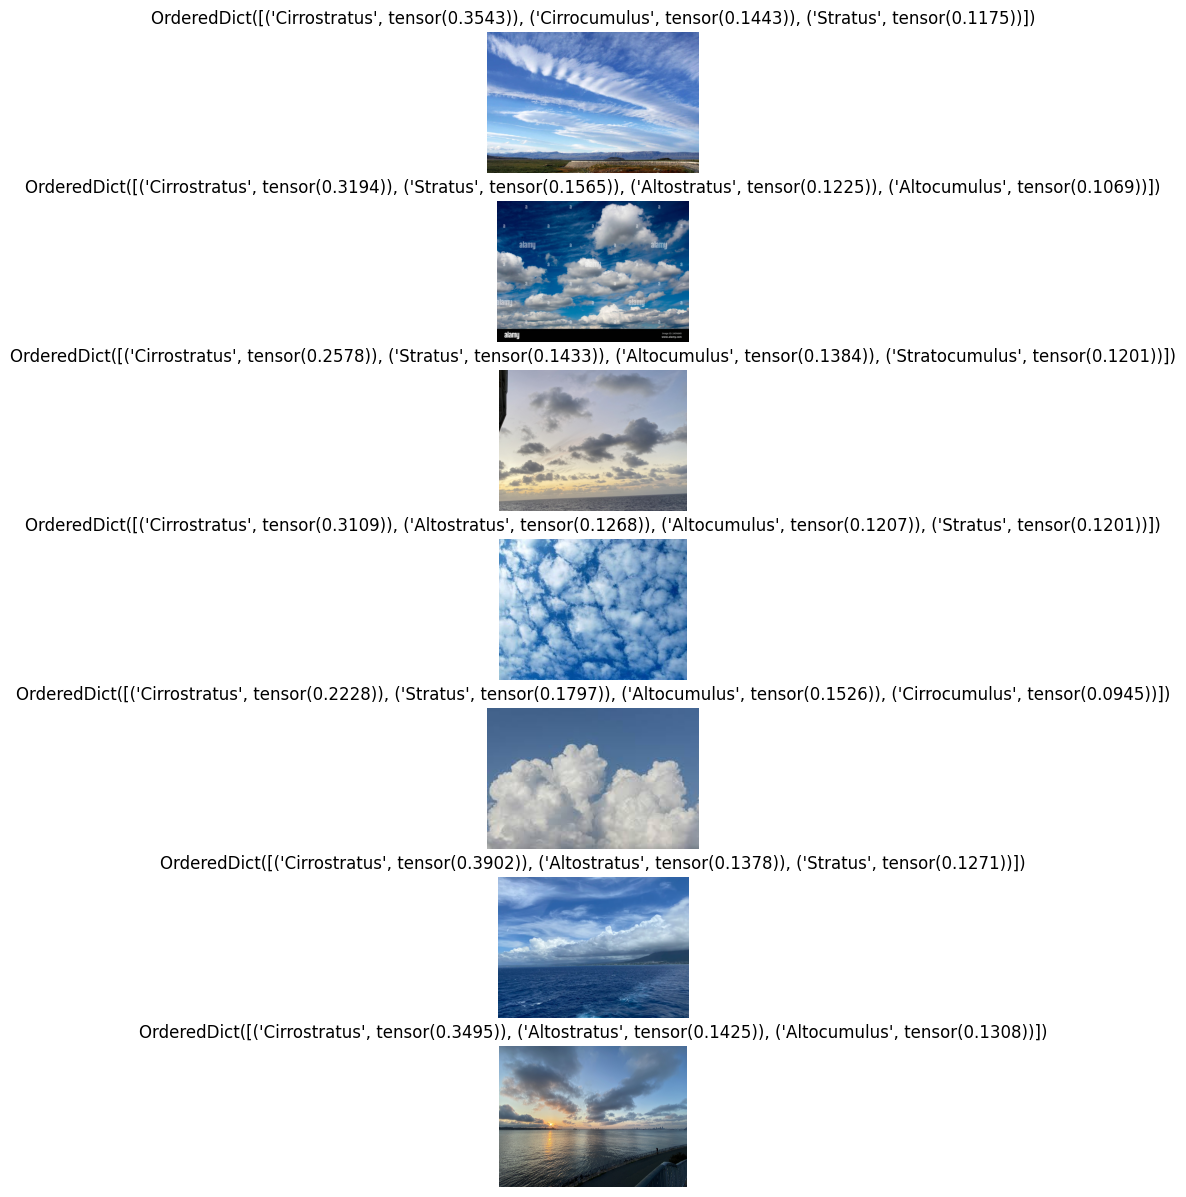

In [20]:
#Testing all w/ no norm:
# pred_n_plot("resnet_notransformslayer2.pth") thinks all is cirrostratus
# pred_n_plot("resnet2.pth") not v confident on anything
# pred_n_plot("resnet_notransformslayer1.pth") # everything is stratus or cirrostratus
# pred_n_plot("resnet_attempt_finallayer4.pth") #No, everything is not, in fact cirrostratus
# pred_n_plot("resnet_finallayer2.pth") #Again, everything is cirrostratus
# pred_n_plot("resnet2 (2).pth") 
# pred_n_plot("resnet2anotherone.pth") fuck no not everything is cs
pred_n_plot("resnet_attempt_final1.pth")  


C:\Users\jseto\AppData\Local\Temp\ipykernel_40408\2891498634.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


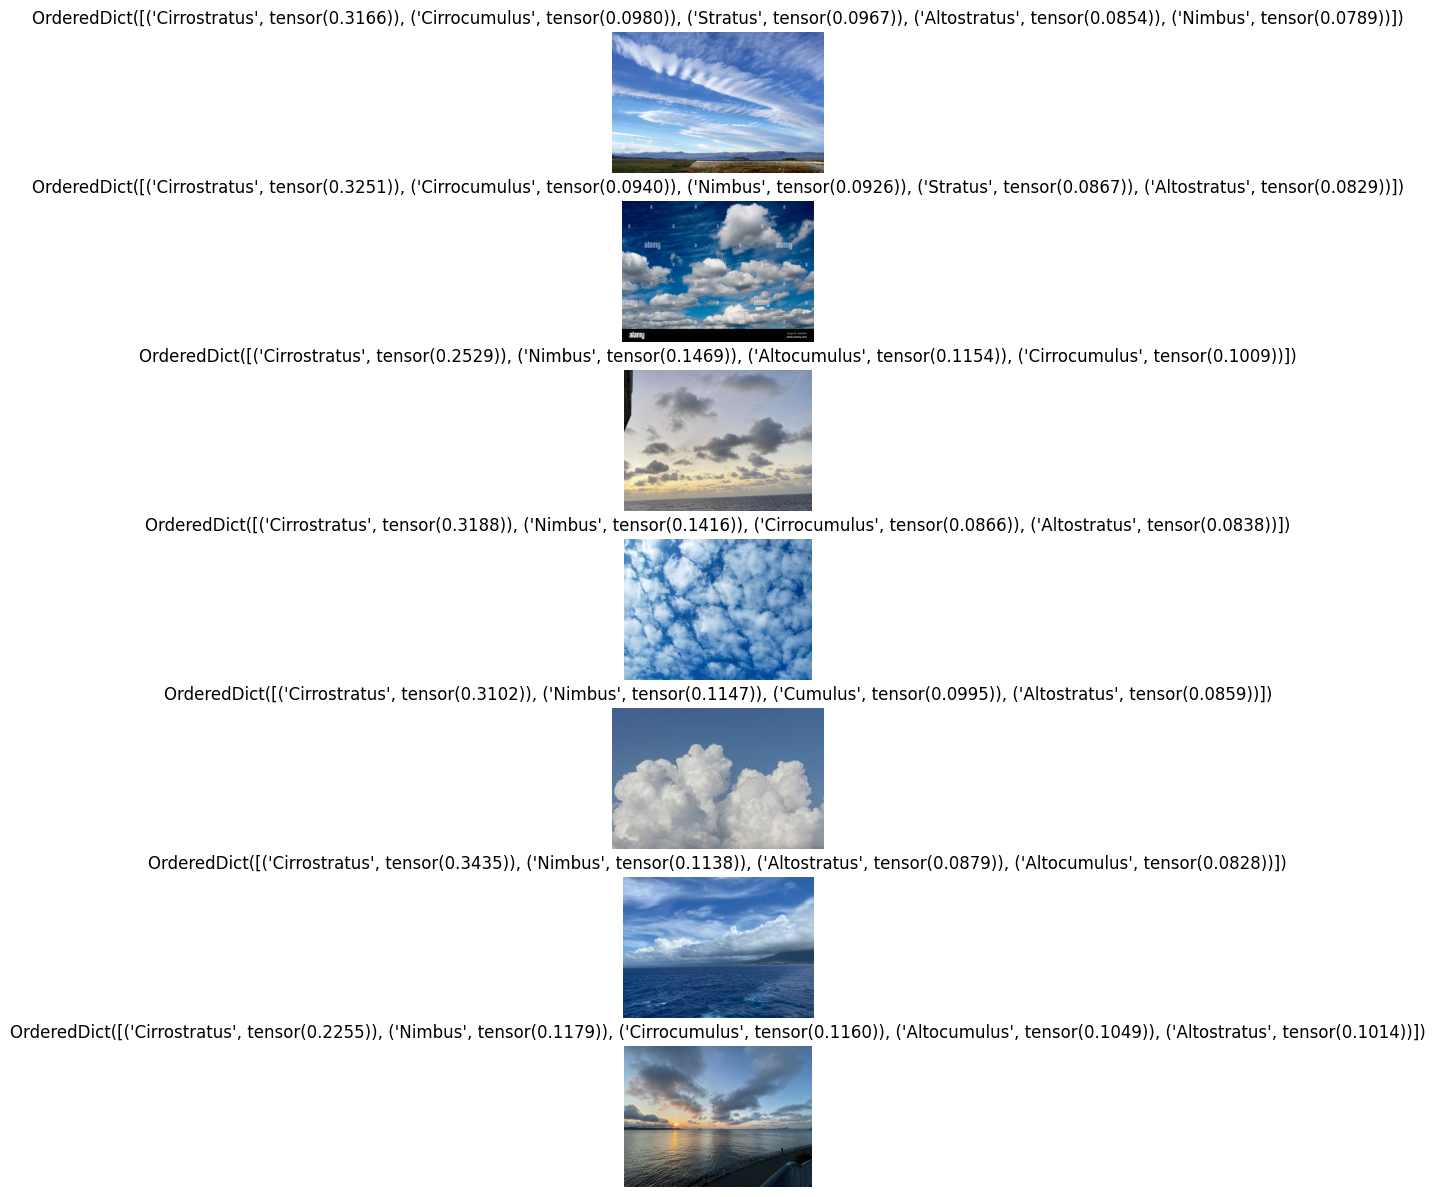

In [16]:
#Testing all w/ norm:
# pred_n_plot("resnet_notransformslayer2.pth") #thinks all is cirrostratus
# pred_n_plot("resnet2.pth") #not v confident on anything
# pred_n_plot("resnet_notransformslayer1.pth") # everything is stratus or cirrostratus
# pred_n_plot("resnet_attempt_finallayer4.pth") #No, everything is not, in fact cirrostratus
# pred_n_plot("resnet_attempt_finallayer2.pth") #Again, everything is cirrostratus
# pred_n_plot("resnet2 (2).pth") 
# pred_n_plot("resnet2anotherone.pth") #fuck no not everything is cs
pred_n_plot("resnet2transforsnonorm.pth")  

C:\Users\jseto\AppData\Local\Temp\ipykernel_16152\2891498634.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


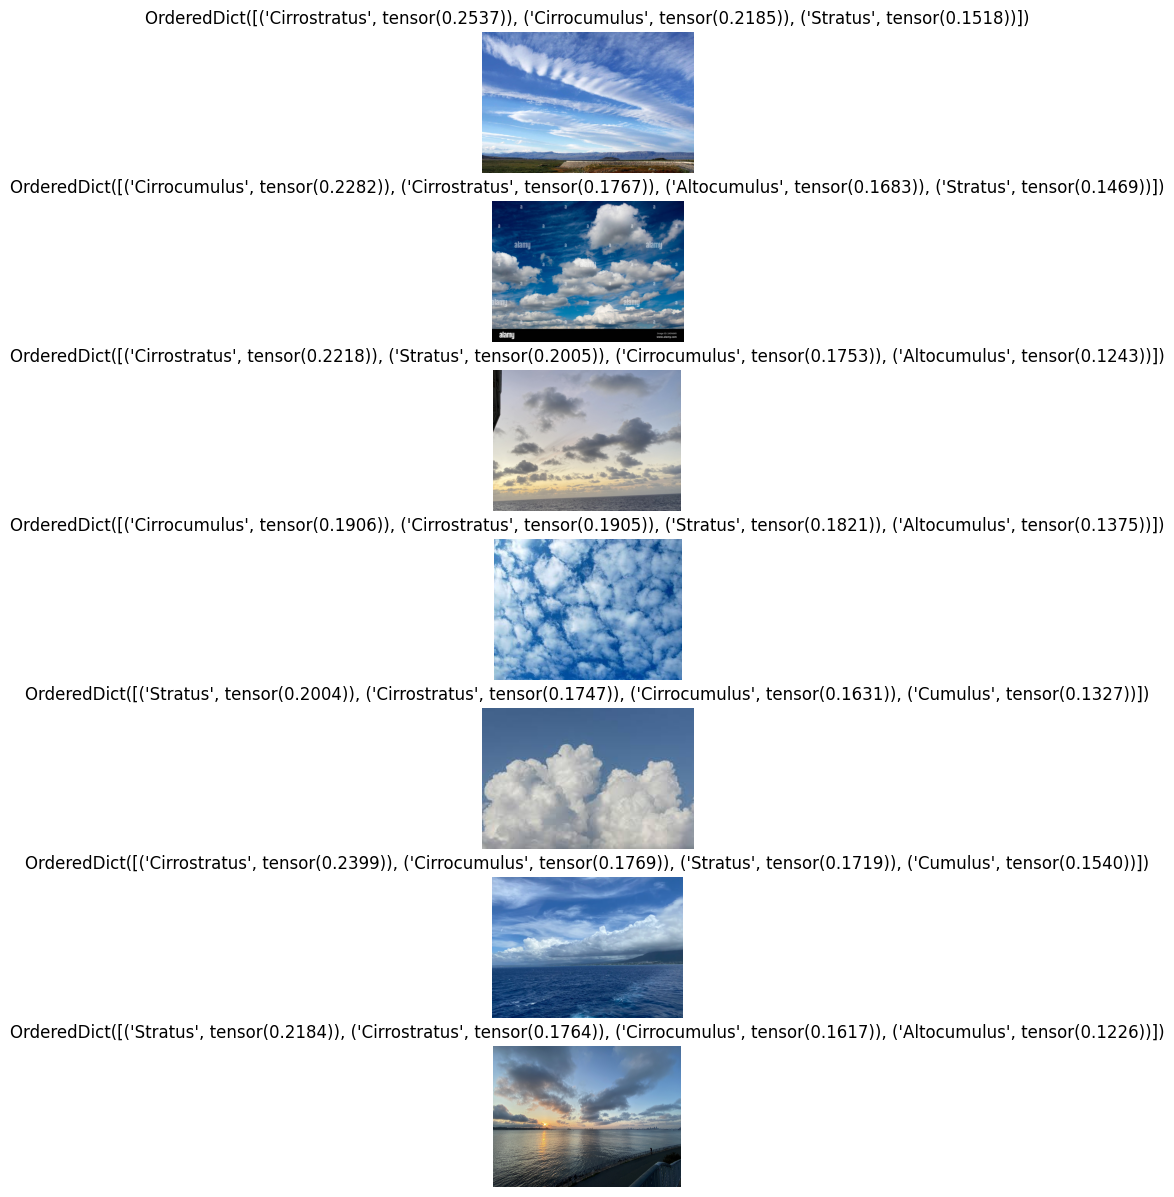